In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
# Getting the training dataset
df = pd.read_csv('data/traindata.csv')
df['ln_hrlyearn'] = np.log(df['hrlyearn'])


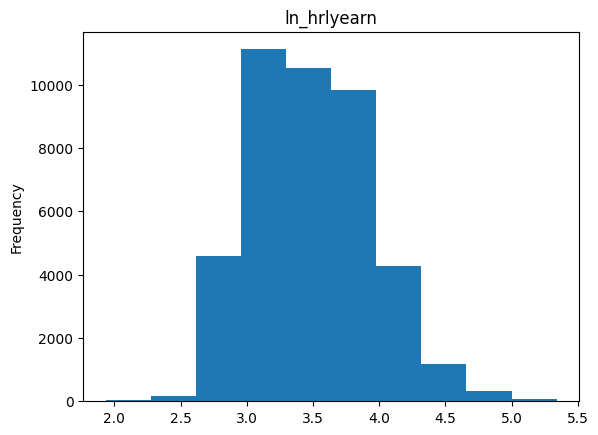

In [5]:
df['ln_hrlyearn'].plot(kind='hist')
plt.title('ln_hrlyearn')
plt.show()

In [27]:
# Generate transformed variables
df['ln_hrlyearn'] = np.log(df['hrlyearn'])
df['age_12_sq'] = df['age_12'] ** 2
df['age_12_cube'] = df['age_12'] ** 3  # Add cubic term
df['tenure_sq'] = df['tenure'] ** 2
df['tenure_cube'] = df['tenure'] ** 3  # Add cubic term
df['educ_tenure'] = df['educ'] * df['tenure']
df['educ_sq'] = df['educ'] ** 2  # Add education squared
df['naics_noc'] = df['naics_21'] * df['noc_10']
df['age_educ'] = df['age_12'] * df['educ']  # Add age-education interaction

# Feature engineering for hours-related variables
df['total_hours'] = df['uhrsmain'] + df['utothrs']
df['overtime_ratio'] = df['xtrahrs'] / (df['uhrsmain'] + 1)  # Add +1 to avoid division by zero

# ============ Linear Regression ============
# Create the formula string for regression
formula = """ln_hrlyearn ~ age_12 + union +cowmain + sex + marstat + educ + 
             uhrsmain + utothrs + hrsaway + unpaidot + xtrahrs + 
             tenure + estsize + firmsize + efamtype + total_hours + overtime_ratio+
             C(prov) + C(naics_21) + C(noc_10)+
             age_12_sq + age_12_cube +tenure_sq + tenure_cube + educ_sq +educ_tenure + naics_noc"""

# Fit the regression model with robust standard errors
linear_model = ols(formula, data=df).fit()
robust_results = linear_model.get_robustcov_results(cov_type='HC1')

# Print linear regression summary
print("Linear Regression Results:")
print(robust_results.summary())

# ============ Gradient Boosting Model ============
# Prepare data for Gradient Boosting
X = pd.concat([
    df[[
        'age_12', "union", "cowmain", 'sex', 'marstat', 'educ',
        'uhrsmain', 'utothrs', 'hrsaway', 'unpaidot', 'xtrahrs',
        'tenure', 'estsize', 'firmsize', 'efamtype',
        'age_12_sq', 'age_12_cube', 'tenure_sq', 'tenure_cube',
        'educ_tenure', 'educ_sq', 'naics_noc', 'age_educ',
        'total_hours', 'overtime_ratio'
    ]],
    pd.get_dummies(df['prov'], prefix='prov'),
    pd.get_dummies(df['naics_21'], prefix='naics'),
    pd.get_dummies(df['noc_10'], prefix='noc_10')
], axis=1)

y = df['ln_hrlyearn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    subsample=1.0,
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=10,
    learning_rate=0.05,
    random_state=42
)

# Fit the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nGradient Boosting Model Results:")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")



# Compare predictions
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print("\nPrediction Sample:")
print(comparison_df.head())

Linear Regression Results:
                            OLS Regression Results                            
Dep. Variable:            ln_hrlyearn   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     775.2
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        03:04:56   Log-Likelihood:                -10551.
No. Observations:               42092   AIC:                         2.123e+04
Df Residuals:                   42030   BIC:                         2.176e+04
Df Model:                          61                                         
Covariance Type:                  HC1                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

/opt/anaconda3/envs/work/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 62, but rank is 60
  warnings.warn('covariance of constraints does not have full '



Gradient Boosting Model Results:
Root Mean Squared Error: 0.2847
R-squared Score: 0.5873

Prediction Sample:
         Actual  Predicted
16511  3.218876   3.182763
12063  3.208825   3.571637
2662   3.362110   3.409299
11568  3.027715   3.333611
27319  2.833213   3.129923


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Model Parameters:
{'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'learning_rate': 0.05}

Gradient Boosting Model Results:
Root Mean Squared Error: 0.2886
R-squared Score: 0.5812

Top 10 Most Important Features:
        feature  importance
21    naics_noc    0.076456
20      educ_sq    0.071392
56     noc_10_1    0.056913
5          educ    0.049746
22     age_educ    0.048753
62     noc_10_7    0.046913
19  educ_tenure    0.042191
11       tenure    0.040186
12      estsize    0.033038
13     firmsize    0.030861


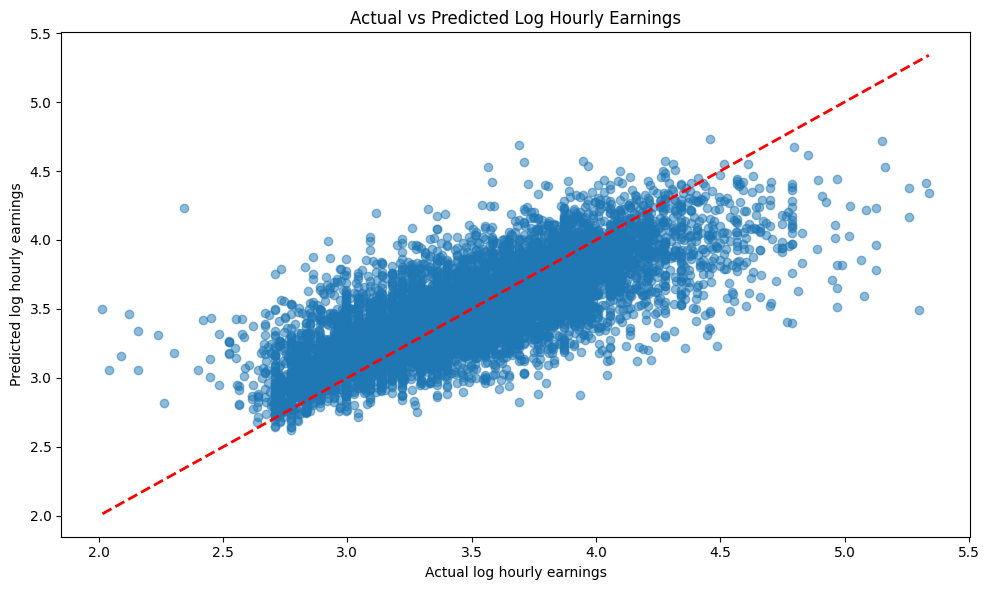

In [25]:
#Doing a random search for hyperparameter tuning

# Generate transformed variables
# Prepare data for Gradient Boosting
X = pd.concat([
    df[[
        'age_12', "union", "cowmain", 'sex', 'marstat', 'educ',
        'uhrsmain', 'utothrs', 'hrsaway', 'unpaidot', 'xtrahrs',
        'tenure', 'estsize', 'firmsize', 'efamtype',
        'age_12_sq', 'age_12_cube', 'tenure_sq', 'tenure_cube',
        'educ_tenure', 'educ_sq', 'naics_noc', 'age_educ',
        'total_hours', 'overtime_ratio'
    ]],
    pd.get_dummies(df['prov'], prefix='prov'),
    pd.get_dummies(df['naics_21'], prefix='naics'),
    pd.get_dummies(df['noc_10'], prefix='noc_10')
], axis=1)

y = df['ln_hrlyearn']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=pd.qcut(y, q=5, labels=False, duplicates='drop')  # Stratify by income quintiles
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gb_model = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    gb_model, 
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Get best model
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nBest Model Parameters:")
print(random_search.best_params_)
print("\nGradient Boosting Model Results:")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual log hourly earnings')
plt.ylabel('Predicted log hourly earnings')
plt.title('Actual vs Predicted Log Hourly Earnings')
plt.tight_layout()
plt.show()


Top 10 Most Important Features:
        feature  importance
4        noc_10    0.327959
3          educ    0.103468
16  educ_tenure    0.093338
17    naics_noc    0.085166
11      estsize    0.041922
1           sex    0.040641
12     firmsize    0.036395
8      unpaidot    0.023170
0        age_12    0.022113
14    age_12_sq    0.021358


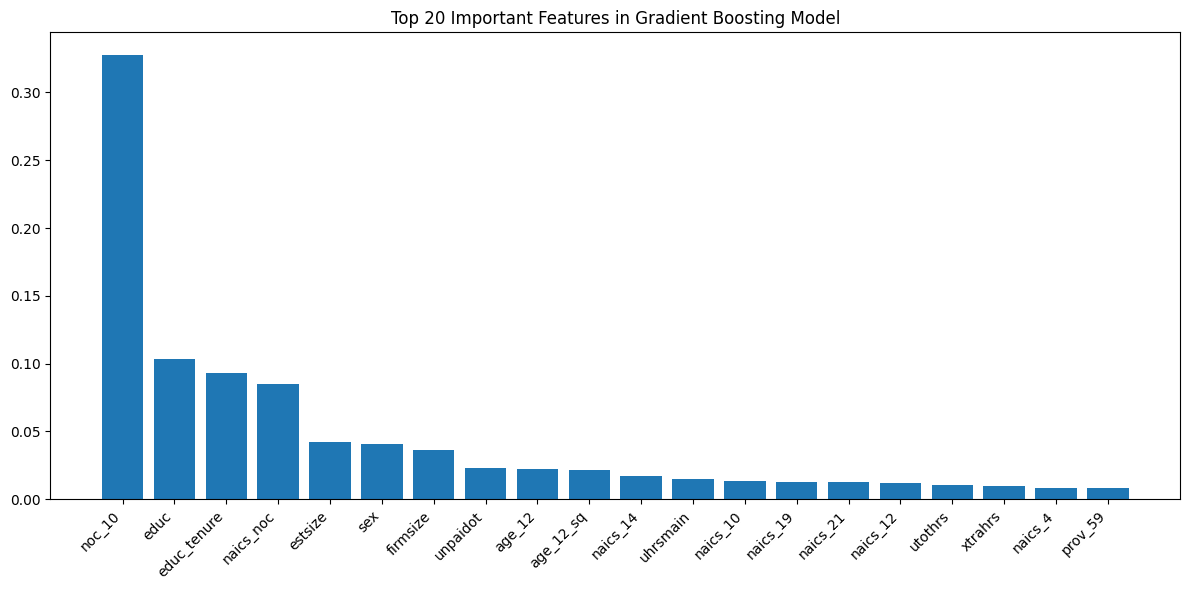

In [15]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(20), importance_df['importance'][:20])
plt.xticks(range(20), importance_df['feature'][:20], rotation=45, ha='right')
plt.title('Top 20 Important Features in Gradient Boosting Model')
plt.tight_layout()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

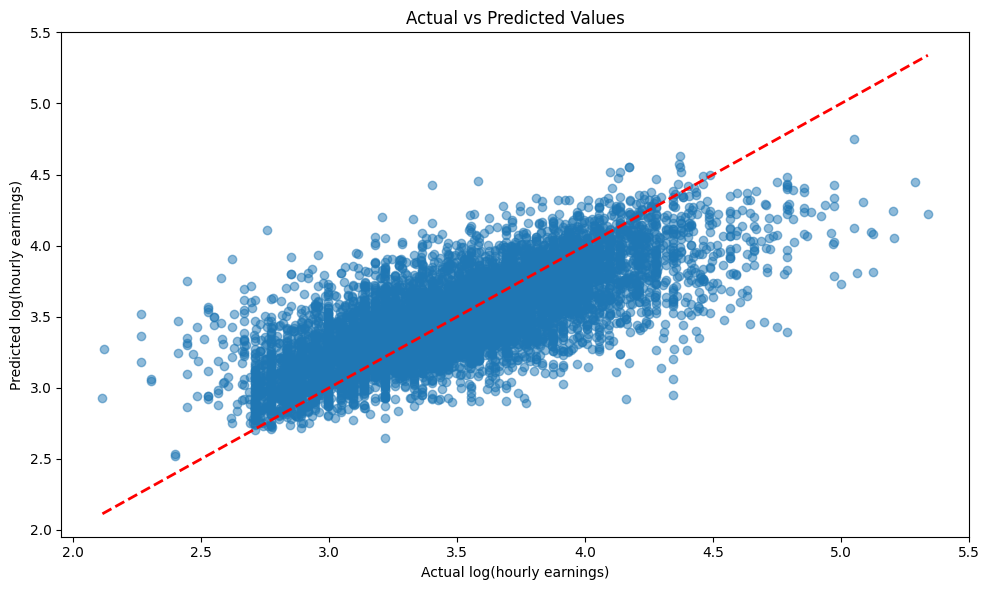

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual log(hourly earnings)')
plt.ylabel('Predicted log(hourly earnings)')
plt.title('Actual vs Predicted Values')
plt.tight_layout()

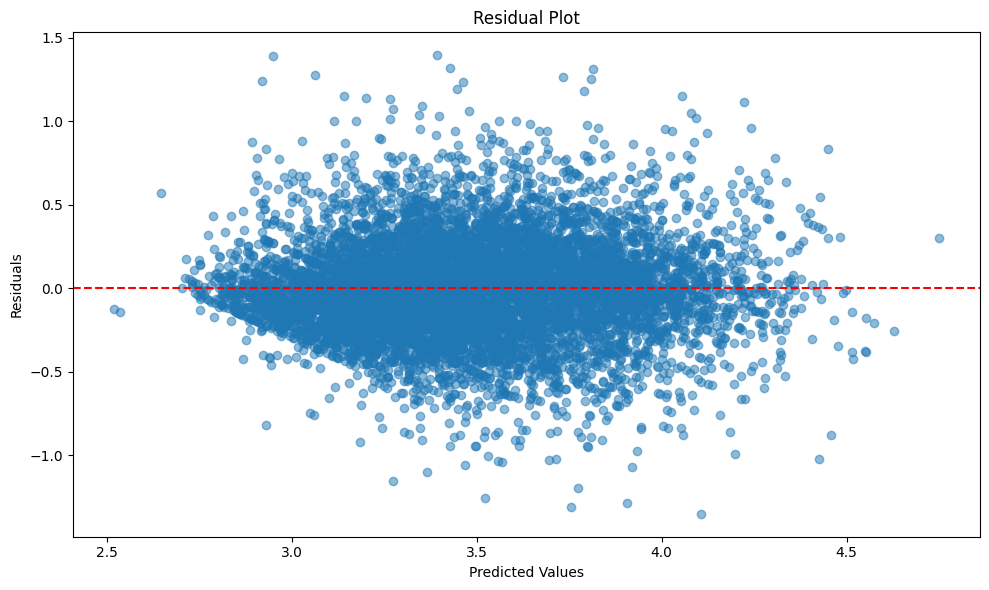

In [18]:
# Residual plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()

In [32]:
# Load evaluation data
eval_df = pd.read_csv('data/evaldata.csv')

# Generate the transformed variables in eval_df
eval_df['age_12_sq'] = eval_df['age_12'] ** 2
eval_df['age_12_cube'] = eval_df['age_12'] ** 3

eval_df['tenure_sq'] = eval_df['tenure'] ** 2
eval_df['tenure_cube'] = eval_df['tenure'] ** 3

eval_df['educ_tenure'] = eval_df['educ'] * eval_df['tenure']
eval_df['educ_sq'] = eval_df['educ'] ** 2

eval_df['naics_noc'] = eval_df['naics_21'] * eval_df['noc_10']
eval_df['age_educ'] = eval_df['age_12'] * eval_df['educ']

eval_df['total_hours'] = eval_df['uhrsmain'] + eval_df['utothrs']
eval_df['overtime_ratio'] = eval_df['xtrahrs'] / (eval_df['uhrsmain'] + 1)

# Prepare features in the same order as training data
X_eval = pd.concat([
    eval_df[[
        'age_12', "union", "cowmain", 'sex', 'marstat', 'educ',
        'uhrsmain', 'utothrs', 'hrsaway', 'unpaidot', 'xtrahrs',
        'tenure', 'estsize', 'firmsize', 'efamtype',
        'age_12_sq', 'age_12_cube', 'tenure_sq', 'tenure_cube',
        'educ_tenure', 'educ_sq', 'naics_noc', 'age_educ',
        'total_hours', 'overtime_ratio'
    ]],
    pd.get_dummies(eval_df['prov'], prefix='prov'),
    pd.get_dummies(eval_df['naics_21'], prefix='naics'),
    pd.get_dummies(eval_df['noc_10'], prefix='noc_10')
], axis=1)

# Ensure X_eval has the same columns as training data
missing_cols = set(X.columns) - set(X_eval.columns)
for col in missing_cols:
    X_eval[col] = 0
X_eval = X_eval[X.columns]

# Make predictions
log_predictions = gb_model.predict(X_eval)

# Transform predictions back from log scale
predictions = np.exp(log_predictions)

# Create submission dataframe
submission = pd.DataFrame({
    'rec_num': eval_df['rec_num'],
    'phrlyearn': predictions
})

# Save submission file
submission.to_csv('data/logicgood.csv', index=False)

# Display first few predictions
print("First few predictions:")
print(submission.head())

# Display summary statistics of predictions
print("\nPrediction Summary Statistics:")
print(submission['phrlyearn'].describe())

First few predictions:
   rec_num   phrlyearn
0   111285   15.391202
1   111288   23.641120
2   111292   17.349804
3   111295   28.880548
4   111299  118.571605

Prediction Summary Statistics:
count    43678.000000
mean        35.044427
std         13.168135
min         10.106370
25%         25.470322
50%         32.082762
75%         41.913177
max        186.330542
Name: phrlyearn, dtype: float64


In [28]:
df['hrlyearn'].describe()


count    42092.000000
mean        36.336892
std         18.385340
min          6.920000
25%         23.500000
50%         31.685000
75%         45.000000
max        208.330000
Name: hrlyearn, dtype: float64